In [1]:
import numpy as np
import tensorflow as tf
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt

# Tensor completion

In this example we will see how can we do tensor completion with t3f, i.e. observe a fraction of values in a tensor and recover the rest by assuming that the original tensor has low TT-rank.
Mathematically it means that we have a binary mask $P$ and a ground truth tensor $A$, but we observe only a noisy and sparsified version of $A$: $P \odot (\hat{A})$, where $\odot$ is the elementwise product (applying the binary mask) and $\hat{A} = A + \text{noise}$. In this case our task reduces to the following optimization problem:
\begin{equation*}
\begin{aligned}
& \underset{X}{\text{minimize}} 
& & \|P \odot (X - \hat{A})\|_F^2 \\
& \text{subject to} 
& & \text{tt_rank}(X) \leq r_0
\end{aligned}
\end{equation*}



### Generating problem instance,
Lets generate a random matrix $A$, noise, and mask $P$.

In [2]:
shape = (3, 4, 4, 5, 7, 5)
# Fix random seed so the results are comparable between runs.
tf.set_random_seed(0)
# Generate ground truth tensor A. To make sure that it has low TT-rank,
# let's generate a random tt-rank 5 tensor and apply t3f.full to it to convert to actual tensor.
ground_truth = t3f.full(t3f.random_tensor(shape, tt_rank=5))
# Make a (non trainable) variable out of ground truth. Otherwise, it will be randomly regenerated on each sess.run.
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
noise = 1e-2 * tf.get_variable('noise', initializer=tf.random_normal(shape), trainable=False)
noisy_ground_truth = ground_truth + noise
# Observe 25% of the tensor values.
sparsity_mask = tf.cast(tf.random_uniform(shape) <= 0.60, tf.float32)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=sparsity_mask, trainable=False)
sparse_observation = noisy_ground_truth * sparsity_mask

### Initialize the variable and compute the loss

In [3]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [4]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [5]:
observed_total = tf.reduce_sum(sparsity_mask)
total = np.prod(shape)
initialization = t3f.random_tensor(shape, tt_rank=5)
estimated = t3f.get_variable('estimated', initializer=initialization)
# Loss is MSE between the estimated and ground-truth tensor as computed in the observed cells.
loss = 1.0 / observed_total * tf.reduce_sum((sparsity_mask * t3f.full(estimated) - sparse_observation)**2)
# Test loss is MSE between the estimated tensor and full (and not noisy) ground-truth tensor A.
test_loss = 1.0 / total * tf.reduce_sum((t3f.full(estimated) - ground_truth)**2)
rel_error1 = relative_error1(t3f.full(estimated), ground_truth)

# SGD optimization
The simplest way to solve the optimization problem is Stochastic Gradient Descent: let TensorFlow differentiate the loss w.r.t. the factors (cores) of the TensorTrain decomposition of the estimated tensor and minimize the loss with your favourite SGD variation.

In [6]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01, epsilon=1e-18)
step = optimizer.minimize(loss)

In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
train_loss_hist = []
test_loss_hist = []
for i in range(10000):
    _, tr_loss_v, test_loss_v, rel_error1_v = sess.run([step, loss, test_loss,rel_error1])
    train_loss_hist.append(tr_loss_v)
    test_loss_hist.append(test_loss_v)
    if i % 1000 == 0:
        print(i, tr_loss_v, test_loss_v, rel_error1_v)

(0, 2.217269, 2.2665322, 2.0411806)
(1000, 0.0018260762, 0.0018757689, 0.05872056)
(2000, 0.00029032555, 0.00022594188, 0.02037975)
(3000, 0.000101705984, 1.9517469e-05, 0.005989799)
(4000, 9.127885e-05, 7.3001643e-06, 0.0036632523)
(5000, 9.219858e-05, 8.0459495e-06, 0.0038458216)
(6000, 9.3027345e-05, 9.543046e-06, 0.0041883597)
(7000, 9.158206e-05, 7.683271e-06, 0.0037581453)
(8000, 9.104519e-05, 7.1536783e-06, 0.0036263126)
(9000, 9.4748364e-05, 1.0235514e-05, 0.0043376586)


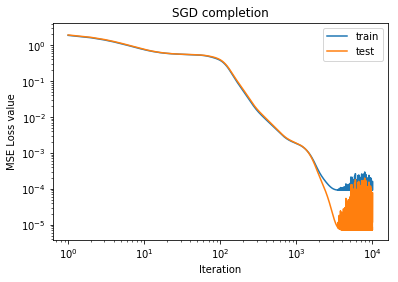

In [8]:
plt.loglog(train_loss_hist, label='train')
plt.loglog(test_loss_hist, label='test')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('SGD completion')
plt.legend()


In [9]:
#ground_truth_var = t3f.get_variable('ground_truth', initializer=ground_truth, reuse=True)

In [10]:
#ground_truth.read_value()
ground_truth_val = ground_truth.eval(session=sess)

In [11]:
estimated_val = sess.run(t3f.full(estimated))

In [12]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [13]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [14]:
rel_error

0.0036293021

# Speeding it up,
The simple solution we have so far assumes that loss is computed by materializing the full estimated tensor and then zeroing out unobserved elements. If the tensors are really large and the fraction of observerd values is small (e.g. less than 1%), it may be much more efficient to directly work only with the observed elements.

In [15]:
tf.reset_default_graph()

shape = (10, 10, 10, 10, 10, 10, 10)

total_observed = np.prod(shape)
# Since now the tensor is too large to work with explicitly,
# we don't want to generate binary mask,
# but we would rather generate indecies of observed cells.

ratio = 0.001

# Let us simply randomly pick some indecies (it may happen
# that we will get duplicates but probability of that
# is 10^(-14) so lets not bother for now)

num_observed = int(ratio * total_observed)
observation_idx = np.random.randint(0, 10, size=(num_observed, len(shape)))
# and let us generate some values of the tensor to be approximated
observations = np.random.randn(num_observed)


In [16]:
# Our strategy is to feed the observation_idx
# into the tensor in the Tensor Train format and compute MSE between
# the obtained values and the desired values

In [17]:
initialization = t3f.random_tensor(shape, tt_rank=16)
estimated = t3f.get_variable('estimated', initializer=initialization)

In [18]:
# To collect the values of a TT tensor (withour forming the full tensor)
# we use the function t3f.gather_nd

In [19]:
estimated_vals = t3f.gather_nd(estimated, observation_idx)
loss = tf.reduce_mean((estimated_vals - observations) ** 2)

In [20]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
step = optimizer.minimize(loss)

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
loss_hist = []

for i in range(2000):
    _, loss_v = sess.run([step, loss])
    loss_hist.append(loss_v)

    if i % 100 == 0:
        print(i, loss_v)

(0, 1.9446722)
(100, 0.065096945)
(200, 0.012110637)
(300, 0.0044138418)
(400, 0.0023044185)
(500, 0.0014333108)
(600, 0.0009344764)
(700, 0.0006643579)
(800, 0.0005172184)
(900, 0.00041211557)
(1000, 0.0003658646)
(1100, 0.00035498556)
(1200, 0.00029656215)
(1300, 0.00027075046)
(1400, 0.00025230506)
(1500, 0.0002364291)
(1600, 0.00020240957)
(1700, 0.00025421896)
(1800, 0.00038237995)
(1900, 0.00025166973)


/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


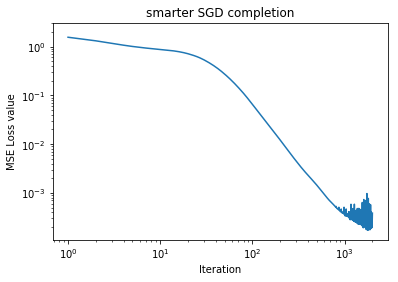

In [22]:
plt.loglog(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('MSE Loss value')
plt.title('smarter SGD completion')
plt.legend()

In [23]:
print(sess.run(t3f.gather_nd(estimated, observation_idx)))

[-0.13055919 -1.4322473  -0.52703154 ...  0.00954324  0.23083258
  0.73654956]


In [24]:
print(observations)

[-1.27225139e-01 -1.37794858e+00 -5.42469328e-01 ... -1.30643336e-03
  2.35629296e-01  7.53320726e-01]


In [25]:
estimated_val = sess.run(t3f.full(estimated))

In [26]:
estimated_val.shape

(10, 10, 10, 10, 10, 10, 10)

In [27]:
#print(estimated_val)

In [28]:
ground_truth.shape

TensorShape([Dimension(3), Dimension(4), Dimension(4), Dimension(5), Dimension(7), Dimension(5)])